## Setup dan Import Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/My Drive/TA_OmarDhani/'

with open(base_path + 'X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open(base_path + 'X_val.pickle', 'rb') as f:
    X_val = pickle.load(f)

with open(base_path + 'X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)

with open(base_path + 'y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

with open(base_path + 'y_val.pickle', 'rb') as f:
    y_val = pickle.load(f)

with open(base_path + 'y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)


In [4]:
# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)


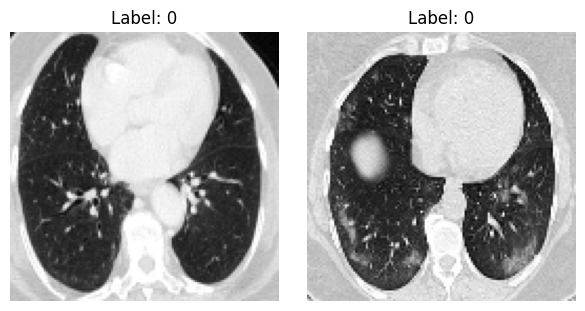

In [5]:
import matplotlib.pyplot as plt
import random

# Pilih sejumlah gambar secara acak dari X_train
num_images = 2
indices = random.sample(range(X_train.shape[0]), num_images)

# Plot gambar
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].reshape(128, 128), cmap='gray')  # Asumsikan gambar grayscale
    plt.title(f"Label: {np.argmax(y_train[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Ensure data is in numpy array format
X_train_rgb = np.array(X_train_rgb)
X_val_rgb = np.array(X_val_rgb)
X_test_rgb = np.array(X_test_rgb)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [7]:
# One-hot encode the labels
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Configure the hyperparameters

In [8]:
input_shape = (128, 128, 3)  # Adjusted for RGB images

weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
batch_size = 128
num_epochs = 100
patch_size = 4  # Size of the patches to be extracted from the input images.
embedding_dim = 64  # Number of hidden units.
mlp_dim = 128
num_heads = 4
attention_dropout = 0.1
projection_dropout = 0.1
num_transformer_blocks = 8

## Use data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomContrast(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train_rgb)

## Implement the patch extraction and encoding layer

In [10]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        batch_size, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_size * self.patch_size * channels])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(positions)

## Implement the external attention block

In [11]:
class ExternalAttention(layers.Layer):
    def __init__(self, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads * dim_coefficient
        self.dim_coefficient = dim_coefficient
        self.attention_dropout = attention_dropout
        self.projection_dropout = projection_dropout

        self.dense1 = layers.Dense(self.dim * self.dim_coefficient)
        self.dense2 = layers.Dense(self.dim // self.dim_coefficient)
        self.dense3 = layers.Dense(self.dim * self.dim_coefficient // self.num_heads)
        self.dense4 = layers.Dense(self.dim)
        self.softmax = layers.Softmax(axis=2)
        self.dropout1 = layers.Dropout(self.attention_dropout)
        self.dropout2 = layers.Dropout(self.projection_dropout)

    def call(self, x):
        batch_size, num_patch, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        x = self.dense1(x)
        x = tf.reshape(x, [batch_size, num_patch, self.num_heads, self.dim * self.dim_coefficient // self.num_heads])
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        attn = self.dense2(x)
        attn = self.softmax(attn)
        attn = tf.keras.layers.Lambda(lambda attn: attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True)))(attn)
        attn = self.dropout1(attn)
        x = self.dense3(attn)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, [batch_size, num_patch, self.dim * self.dim_coefficient])
        x = self.dense4(x)
        x = self.dropout2(x)
        return x

## Implement the MLP block

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement the Transformer block

In [13]:
def transformer_encoder(x, embed_dim, num_heads, mlp_dim, dropout, attention_type="self_attention"):
    # Normalization and Attention Mechanism
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    if attention_type == "external_attention":
        attention_output = ExternalAttention(
            dim=embed_dim, num_heads=num_heads, attention_dropout=dropout, projection_dropout=dropout
        )(x1)
    else:
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout
        )(x1, x1)

    # Skip connection
    x2 = layers.Add()([attention_output, x])

    # Normalization and MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=[mlp_dim, embed_dim], dropout_rate=dropout)

    # Skip connection
    return layers.Add()([x3, x2])

## Implement the EANet model

The EANet model leverages external attention.
The computational complexity of traditional self attention is `O(d * N ** 2)`,
where `d` is the embedding size, and `N` is the number of patch.
the authors find that most pixels are closely related to just a few other
pixels, and an `N`-to-`N` attention matrix may be redundant.
So, they propose as an alternative an external
attention module where the computational complexity of external attention is `O(d * S * N)`.
As `d` and `S` are hyper-parameters,
the proposed algorithm is linear in the number of pixels. In fact, this is equivalent
to a drop patch operation, because a lot of information contained in a patch
in an image is redundant and unimportant.

In [14]:
def create_eat_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = PatchExtract(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEmbedding((input_shape[0] // patch_size) ** 2, embedding_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        encoded_patches = transformer_encoder(
            encoded_patches, embedding_dim, num_heads, mlp_dim, attention_dropout, attention_type="external_attention"
        )

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=[2048, 1024], dropout_rate=0.3)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Pelatihan Model pada Dataset COVID-19

In [15]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=label_smoothing),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/My Drive/TA_OmarDhani/checkpoint_Scheme_2.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        X_train_rgb,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val_rgb, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test_rgb, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

# Function to save history
def save_history(history, history_directory, history_filename):
    history_path = os.path.join(history_directory, history_filename)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

# Function to load history
def load_history(history_directory, history_filename):
    history_path = os.path.join(history_directory, history_filename)
    with open(history_path, 'rb') as f:
        return pickle.load(f)

eat_classifier = create_eat_classifier()
history = run_experiment(eat_classifier)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5062 - loss: 38.0526 - val_accuracy: 0.6583 - val_loss: 1.1792
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 852ms/step - accuracy: 0.5618 - loss: 3.5639 - val_accuracy: 0.5566 - val_loss: 1.4427
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.5896 - loss: 1.7320 - val_accuracy: 0.5873 - val_loss: 0.9367
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6058 - loss: 1.1119 - val_accuracy: 0.7102 - val_loss: 0.6854
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.6341 - loss: 0.9464 - val_accuracy: 0.6526 - val_loss: 0.6566
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.6371 - loss: 0.7738 - val_accuracy: 0.7063 - val_loss: 0.6011
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.6496 - loss: 0.6708 - val_accuracy: 0.6891 - val_loss: 0.6550
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 855ms/step - accuracy: 0.6390 - loss: 0.6890 - val_accurac

## Visualisasi Proses Pelatihan

In [16]:
# Save the history
history_directory = "/content/drive/My Drive/TA_OmarDhani/"
history_filename = "history_Scheme2.pkl"
save_history(history, history_directory, history_filename)

## Evaluasi Model pada Dataset Uji

In [17]:
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()

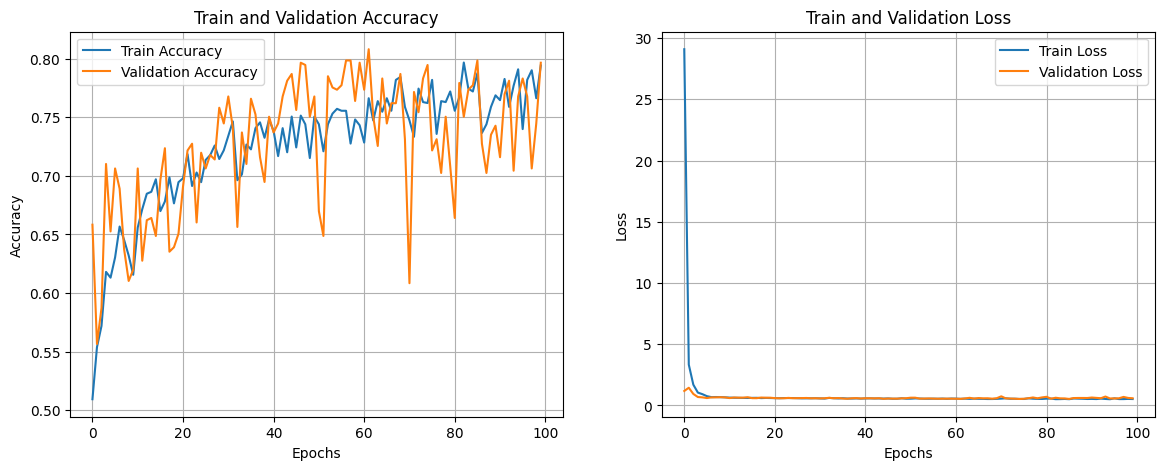

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       369
           1       0.88      0.69      0.77       376

    accuracy                           0.79       745
   macro avg       0.81      0.80      0.79       745
weighted avg       0.81      0.79      0.79       745



In [18]:
# Load the history and plot
loaded_history = load_history(history_directory, history_filename)
plot_history(loaded_history)

# Get predictions
y_pred = eat_classifier.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

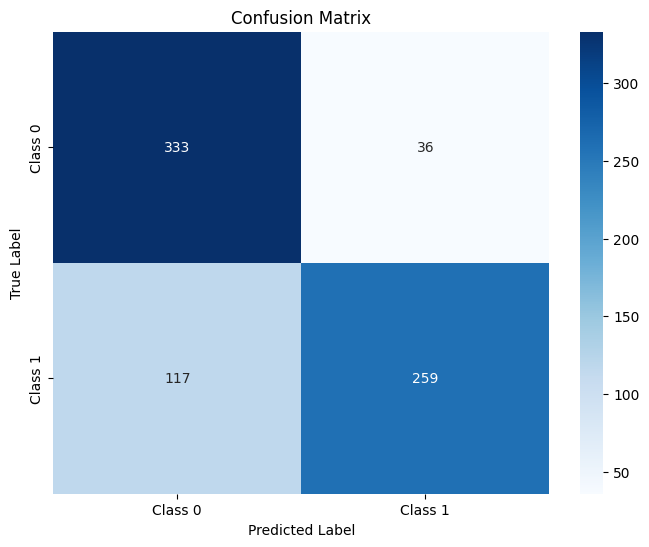

In [19]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()